<a href="https://colab.research.google.com/github/Guo0911/generative_ai/blob/main/%5BGenerative_AI%5D_Homework_02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. 導入套件

### 安裝 Gradio

In [1]:
!pip install gradio

### 導入套件

In [2]:
import numpy as np
import gradio as gr
import matplotlib.pyplot as plt

from PIL import Image
from ipywidgets import interact_manual

# TensorFlow
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD

### 額外設定

In [3]:
# 讓 Colab 不會輸出警告或非必要的訊息
import warnings
warnings.filterwarnings("ignore")

# 讓 Matplotlib 圖表在 Jupyter Notebook 中直接顯示
%matplotlib inline

## 2. Dataset

### 使用 MNIST Dataset
 - 含有許多手寫數字 0 - 9 的影像數據
  - 訓練集共有 6 萬筆資料
  - 測試集共有 1 萬筆資料

In [4]:
# 由 Keras 直接下載並載入 MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [5]:
# 檢查資料筆數
print(f'訓練資料總筆數為 {len(x_train)} 筆資料')
print(f'測試資料總筆數為 {len(x_test)} 筆資料')

訓練資料總筆數為 60000 筆資料
測試資料總筆數為 10000 筆資料


### 觀察影像和標記

In [6]:
def show_image_and_label(n=0):
    ax = plt.gca()

    X = x_train[n]

    plt.xticks([], []) # 把 x 軸的刻度拿掉
    plt.yticks([], []) # 把 y 軸的刻度拿掉

    plt.imshow(X, cmap = 'Greys')
    print(f'這張影像的標記是 {y_train[n]}')

interact_manual(show_image_and_label, n=(0,59999));

interactive(children=(IntSlider(value=0, description='n', max=59999), Button(description='Run Interact', style…

### Normalize

目前的影像資料是一個 $28 \times 28$ 的陣列，並且數值範圍為 0 ~ 255
 - 把影像資料從 2D 轉為 1D
 - 將數值做 Normalize

In [7]:
# 顯示數值範圍
print('所有影像中最大的數值為:', x_train.max())
print('所有影像中最小的數值為:', x_train.min())

所有影像中最大的數值為: 255
所有影像中最小的數值為: 0


In [8]:
# 把數值 Normalize 到 [0, 1] 的區間
x_train = x_train.reshape(60000, 784)/255
x_test = x_test.reshape(10000, 784)/255

# 顯示數值範圍
print('所有影像中最大的數值為:', x_train.max())
print('所有影像中最小的數值為:', x_train.min())

所有影像中最大的數值為: 1.0
所有影像中最小的數值為: 0.0


### 調整 label 方式

目前的 label 是直接輸出數值 (例如影像是 5 的話，標記就是 5)

但通常 Classfication 的任務會透過 one-hot-encoding 的方式輸出結果
 - 例如，有三個類別 [ 貓, 狗, 人 ] 則標記為貓時應該是 [ 1, 0, 0 ]

因此需要調整目前標記的方式，讓每個標記都是一個陣列，並且在對應位置的數值為 1，其他為 0

In [9]:
print(f'訓練集的第一筆資料目前的 label 是', y_train[0])
print(f'測試集的第一筆資料目前的 label 是', y_test[0])

y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

print(f'調整後，訓練集的第一筆資料的 label 是', y_train[0])
print(f'調整後，測試集的第一筆資料的 label 是', y_test[0])

訓練集的第一筆資料目前的 label 是 5
測試集的第一筆資料目前的 label 是 7
調整後，訓練集的第一筆資料的 label 是 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
調整後，測試集的第一筆資料的 label 是 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]


## 3. 設定 NN 的架構

因為後面 training 時會測試不同參數的效果，所以這邊改成用 function 來建構 NN

In [10]:
def create_model(dim=[20, 15, 10], loss_function='mse'): # dim 是一個陣列，決定每層的維度
  nn = Sequential()

  # input layer 與影像大小相同，因此需要設定為 784，並使用 ReLU 作為激活函數
  nn.add(Dense(dim[0], input_dim=784, activation='relu'))

  # hidden layer，依照傳入的 dim 來決定層數和維度
  for d in dim[1:]:
    nn.add(Dense(d, activation='relu'))

  # output layer
  nn.add(Dense(10, activation='softmax')) # 使用 Softmax 讓所有類別的機率總合為 1

  # 模型的 Loss Function 採用 MSE
  nn.compile(loss=loss_function, optimizer=SGD(learning_rate=0.087), metrics=['accuracy'])

  return nn

model = create_model()

# 檢視 NN 的架構
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 20)                  │          15,700 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 15)                  │             315 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 10)                  │             160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 10)                  │             110 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,285 (63.61 KB)

 Trainable params: 16,285 (63.61 KB)

 Non-trainable params: 0 (0.00 B)

## 4. 訓練 NN

In [11]:
# 需要設定 batch size 和 epochs
# 其中 batch size 代表一次要訓練多少筆資料，例如 100 就是每次都從 100 張影像中學習 (因為有 6 萬張影像，所以會學習 600 次)
# 而 epochs 代表要重複學習多少次，假設 epochs 為 2，則代表會把 6 萬張影像都學習過 2 次

model_1 = create_model(dim=[20, 20, 20]) # 跟範例一樣的設定
model_1.fit(x_train, y_train, batch_size=100, epochs=10)

Epoch 1/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.1018 - loss: 0.0894
Epoch 2/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.2520 - loss: 0.0842
Epoch 3/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.4691 - loss: 0.0726
Epoch 4/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6226 - loss: 0.0550
Epoch 5/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7857 - loss: 0.0357
Epoch 6/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8375 - loss: 0.0259
Epoch 7/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8565 - loss: 0.0227
Epoch 8/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8689 - loss: 0.0203
Epoch 9/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8776 - loss: 0.0191
Epoch 10/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8837 - loss: 0.0180


In [12]:
# 測試增加模型層數和 epochs 嘗試提高準確率

model_2 = create_model(dim=[20, 20, 20, 20, 20])
model_2.fit(x_train, y_train, batch_size=100, epochs=30)

Epoch 1/30
600/600 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.1190 - loss: 0.0900
Epoch 2/30
600/600 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.1738 - loss: 0.0892
Epoch 3/30
600/600 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.2017 - loss: 0.0866
Epoch 4/30
600/600 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.3692 - loss: 0.0790
Epoch 5/30
600/600 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4616 - loss: 0.0691
Epoch 6/30
600/600 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5729 - loss: 0.0560
Epoch 7/30
600/600 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6650 - loss: 0.0431
Epoch 8/30
600/600 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7605 - loss: 0.0338
Epoch 9/30
600/600 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8155 - loss: 0.0278
Epoch 10/30
600/600 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8479 - loss: 0.0228
Epoch 11/30
600/600 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8725 - loss: 0.0194
Epoch 12/30
600/600 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

In [13]:
# 測試調整 batch size 的影響

model_3 = create_model(dim=[20, 20, 20, 20, 20])
model_3.fit(x_train, y_train, batch_size=200, epochs=30)

Epoch 1/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.1010 - loss: 0.0900
Epoch 2/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.1077 - loss: 0.0899
Epoch 3/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.1217 - loss: 0.0897
Epoch 4/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.1397 - loss: 0.0894
Epoch 5/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.1461 - loss: 0.0890
Epoch 6/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.1485 - loss: 0.0876
Epoch 7/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.2171 - loss: 0.0854
Epoch 8/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.2499 - loss: 0.0837
Epoch 9/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.2567 - loss: 0.0832
Epoch 10/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2608 - loss: 0.0826
Epoch 11/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.2712 - loss: 0.0821
Epoch 12/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

## 5. 模型評估

在 testset 的 accuracy 高低與 training 時的結果相似，還沒有出現 overfitting 的狀況

 - batch size 較高的 NN 表現較差，可能需要再調整其他參數 (例如降低 learning rate)

In [14]:
# 測試三個 model 在 testset 的表現

loss, acc = model_1.evaluate(x_test, y_test)
print(f"第一個 model 在 testset 的準確率 {acc*100:.2f}%")

loss, acc = model_2.evaluate(x_test, y_test)
print(f"第二個 model 在 testset 的準確率 {acc*100:.2f}%")

loss, acc = model_3.evaluate(x_test, y_test)
print(f"第三個 model 在 testset 的準確率 {acc*100:.2f}%")

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8762 - loss: 0.0189
第一個 model 在 testset 的準確率 88.65%
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9211 - loss: 0.0119
第二個 model 在 testset 的準確率 93.02%
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8083 - loss: 0.0289
第三個 model 在 testset 的準確率 83.31%


### 6. 用 Gradio 來展示

In [15]:
def resize_image(inp):
    # 圖在 inp["layers"][0]
    image = np.array(inp["layers"][0], dtype=np.float32)
    image = image.astype(np.uint8)

    # 轉成 PIL 格式
    image_pil = Image.fromarray(image)

    # Alpha 通道設為白色, 再把圖從 RGBA 轉成 RGB
    background = Image.new("RGB", image_pil.size, (255, 255, 255))
    background.paste(image_pil, mask=image_pil.split()[3]) # 把圖片粘貼到白色背景上，使用透明通道作為遮罩
    image_pil = background

    # 轉換為灰階圖像
    image_gray = image_pil.convert("L")

    # 將灰階圖像縮放到 28x28, 轉回 numpy array
    img_array = np.array(image_gray.resize((28, 28), resample=Image.LANCZOS))

    # 配合 MNIST 數據集
    img_array = 255 - img_array

    # 拉平並縮放
    img_array = img_array.reshape(1, 784) / 255.0

    return img_array

In [16]:
def recognize_digit(inp):
    img_array = resize_image(inp)
    prediction = model_2.predict(img_array).flatten() # 要記得換上面測試最好的 model
    labels = list('0123456789')
    return {labels[i]: float(prediction[i]) for i in range(10)}

In [17]:
iface = gr.Interface(
    fn=recognize_digit,
    inputs=gr.Sketchpad(),
    outputs=gr.Label(num_top_classes=3),
    title="MNIST 手寫辨識",
    description="請在畫板上繪製數字"
)

iface.launch(share=True, debug=True)

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://2bff5c1326010c3b77.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 505ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://2bff5c1326010c3b77.gradio.live


### Gradio 的截圖

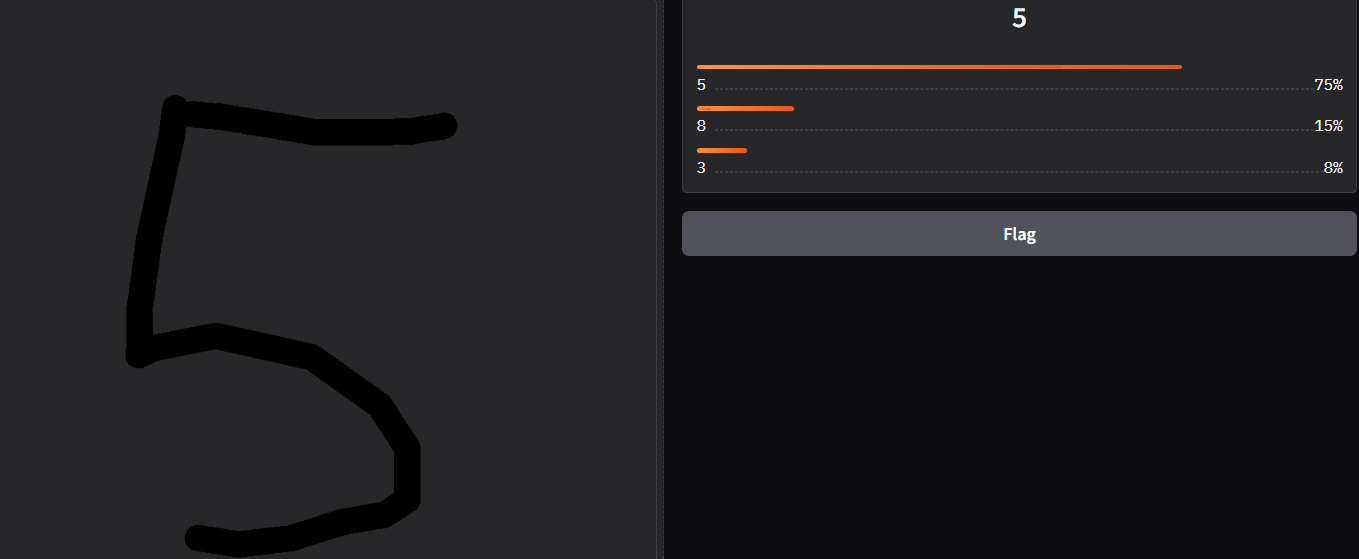